In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

In [2]:
#data load
data = pd.read_csv("Data/loan_data.csv")
data.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [3]:
#dataset shape
print(f'The dataset has {data.shape[0]} rows and {data.shape[1]} columns.')

The dataset has 45000 rows and 14 columns.


In [4]:
#data type
data.dtypes

person_age                        float64
person_gender                      object
person_education                   object
person_income                     float64
person_emp_exp                      int64
person_home_ownership              object
loan_amnt                         float64
loan_intent                        object
loan_int_rate                     float64
loan_percent_income               float64
cb_person_cred_hist_length        float64
credit_score                        int64
previous_loan_defaults_on_file     object
loan_status                         int64
dtype: object

In [5]:
#check null value
print(f'The dataset has {data.isna().sum().sum()} null values.')

The dataset has 0 null values.


In [6]:
#check duplicate value
print(f'The dataset has {data.duplicated().sum()} duplicate values.')

The dataset has 0 duplicate values.


In [7]:
# Descriptive statistics for numerical columns
data.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


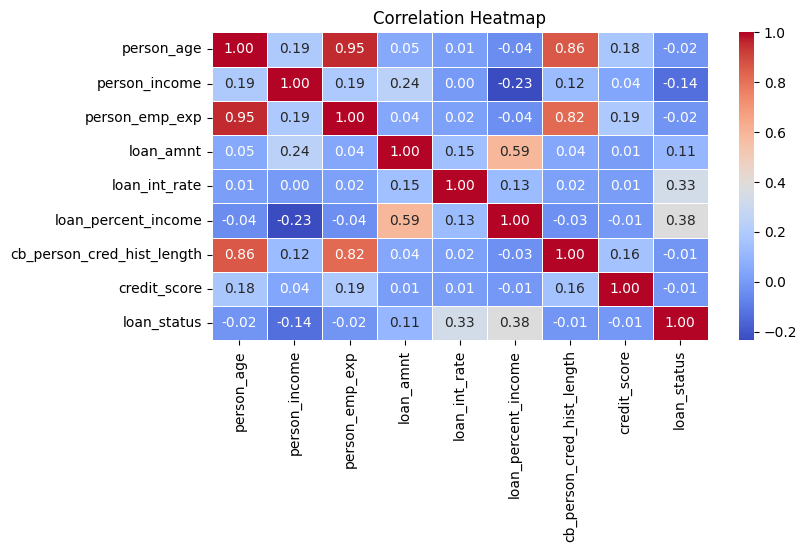

In [10]:
# Step 6: Check correlations
# Select only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

Highly Correlated Feature Pairs (Threshold > 0.8):
                    Feature 1                   Feature 2  Correlation
0                  person_age              person_emp_exp     0.954412
2              person_emp_exp                  person_age     0.954412
1                  person_age  cb_person_cred_hist_length     0.861985
4  cb_person_cred_hist_length                  person_age     0.861985
3              person_emp_exp  cb_person_cred_hist_length     0.824272
5  cb_person_cred_hist_length              person_emp_exp     0.824272


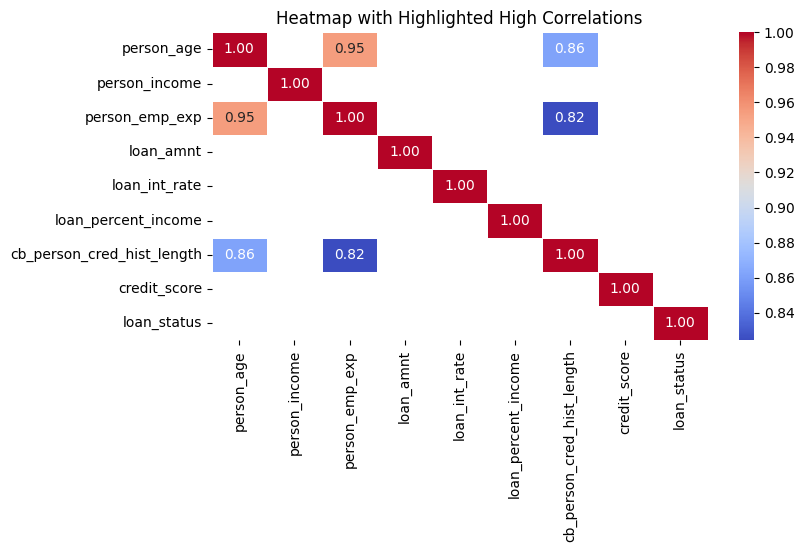

In [11]:
# Step: Check for Multicollinearity
# Set a threshold for high correlation (e.g., 0.8)
threshold = 0.8

# Find pairs of highly correlated features
high_corr = correlation_matrix[(correlation_matrix >= threshold) & (correlation_matrix < 1.0)]

# Display the features with high correlation
high_corr_pairs = high_corr.stack().reset_index()
high_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corr_pairs = high_corr_pairs.sort_values(by='Correlation', ascending=False)

print("Highly Correlated Feature Pairs (Threshold > 0.8):")
print(high_corr_pairs)

# Highlight high correlations on the heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, 
            mask=~(correlation_matrix.abs() >= threshold))
plt.title("Heatmap with Highlighted High Correlations")
plt.show()

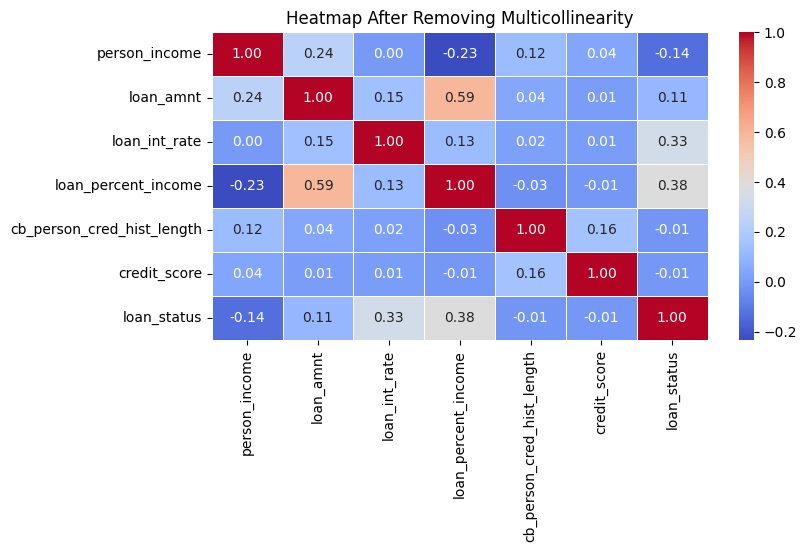

Dropped features to reduce multicollinearity: ['person_emp_exp' 'person_age']


In [12]:
# Keep only numeric columns
data_numeric = data.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix_before = data_numeric.corr()

# Set a threshold for high correlation
threshold = 0.8

# Identify highly correlated feature pairs
high_corr_pairs = correlation_matrix_before.abs().unstack().reset_index()
high_corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]
high_corr_pairs = high_corr_pairs[(high_corr_pairs["Feature 1"] != high_corr_pairs["Feature 2"]) & 
                                  (high_corr_pairs["Correlation"] > threshold)]

# Keep only unique pairs (avoid duplicate pairs)
high_corr_pairs = high_corr_pairs[high_corr_pairs["Feature 1"] < high_corr_pairs["Feature 2"]]

# Drop one feature from each highly correlated pair
drop_features = high_corr_pairs["Feature 2"].unique()
data_cleaned = data_numeric.drop(columns=drop_features)

# Compute the correlation matrix after dropping features
correlation_matrix_after = data_cleaned.corr()

# Plot heatmap AFTER removing multicollinearity (with values)
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix_after, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap After Removing Multicollinearity")
plt.show()

# Print dropped features
print(f"Dropped features to reduce multicollinearity: {drop_features}")

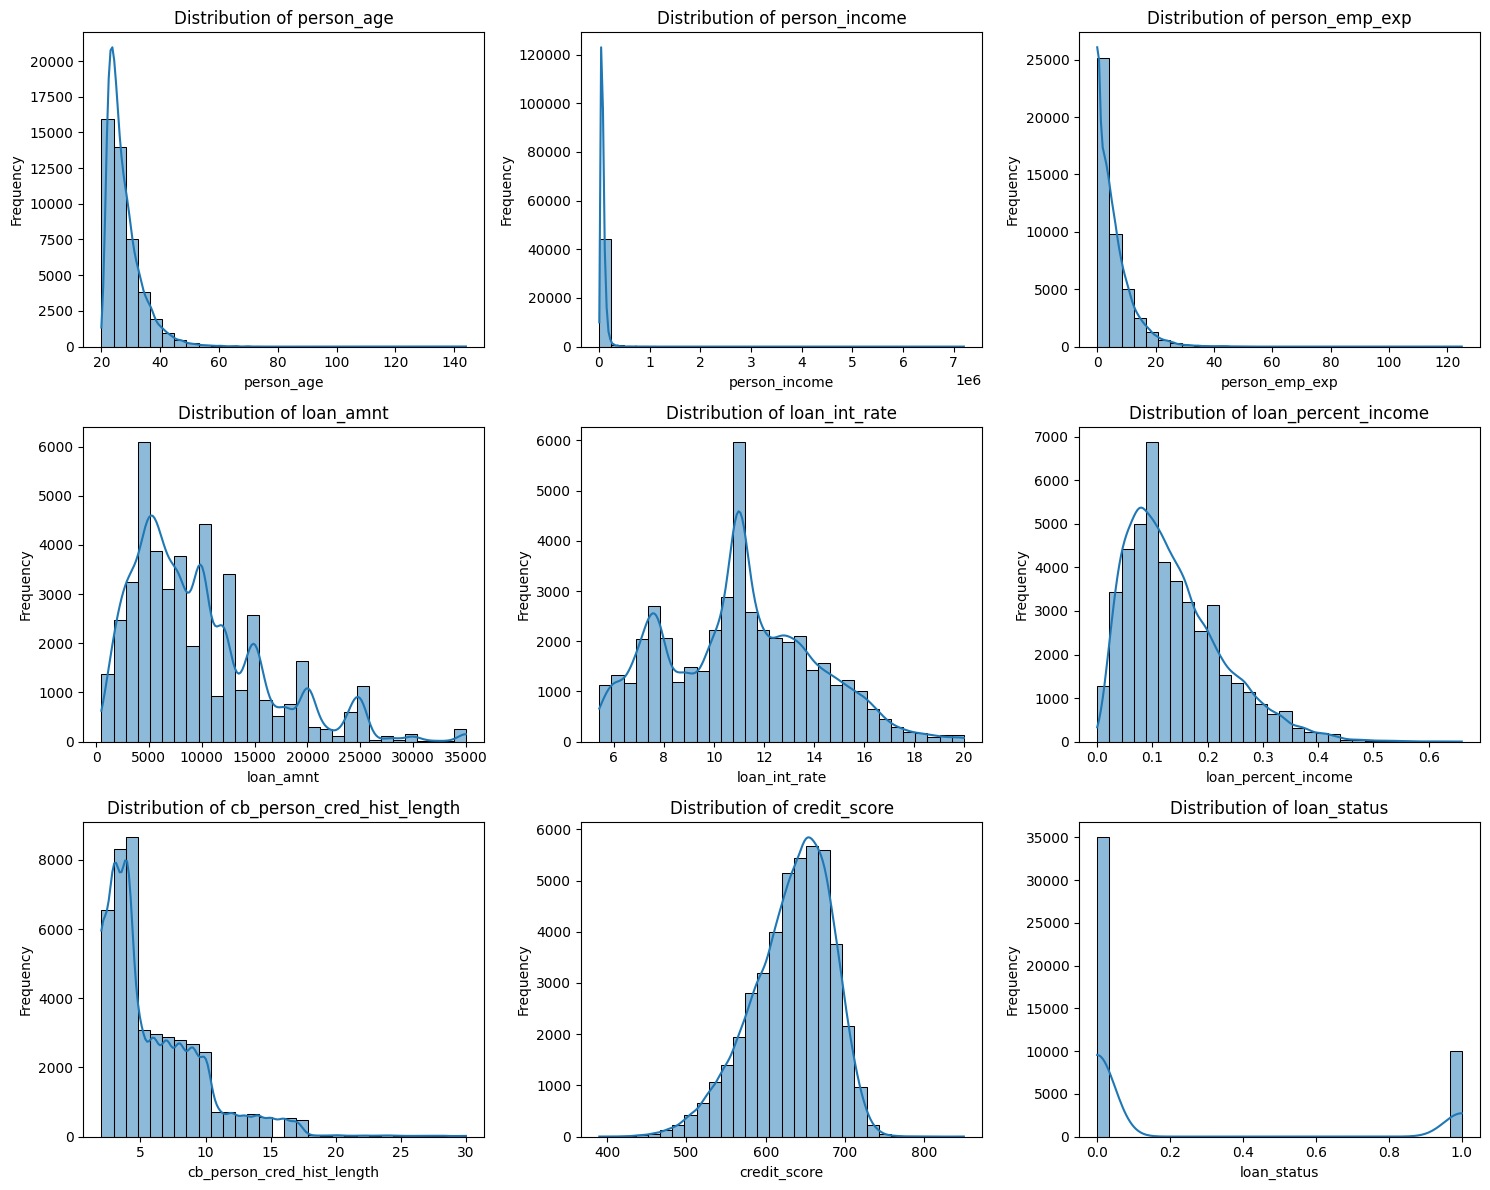

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Select numerical columns
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Define number of columns for subplots
num_cols = 3  # Number of histograms per row
num_rows = -(-len(numeric_columns) // num_cols)  # Compute required rows (ceiling division)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()  # Flatten in case of multiple rows

# Plot histograms
for i, col in enumerate(numeric_columns):
    sns.histplot(data[col], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Hide unused subplots (if any)
for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

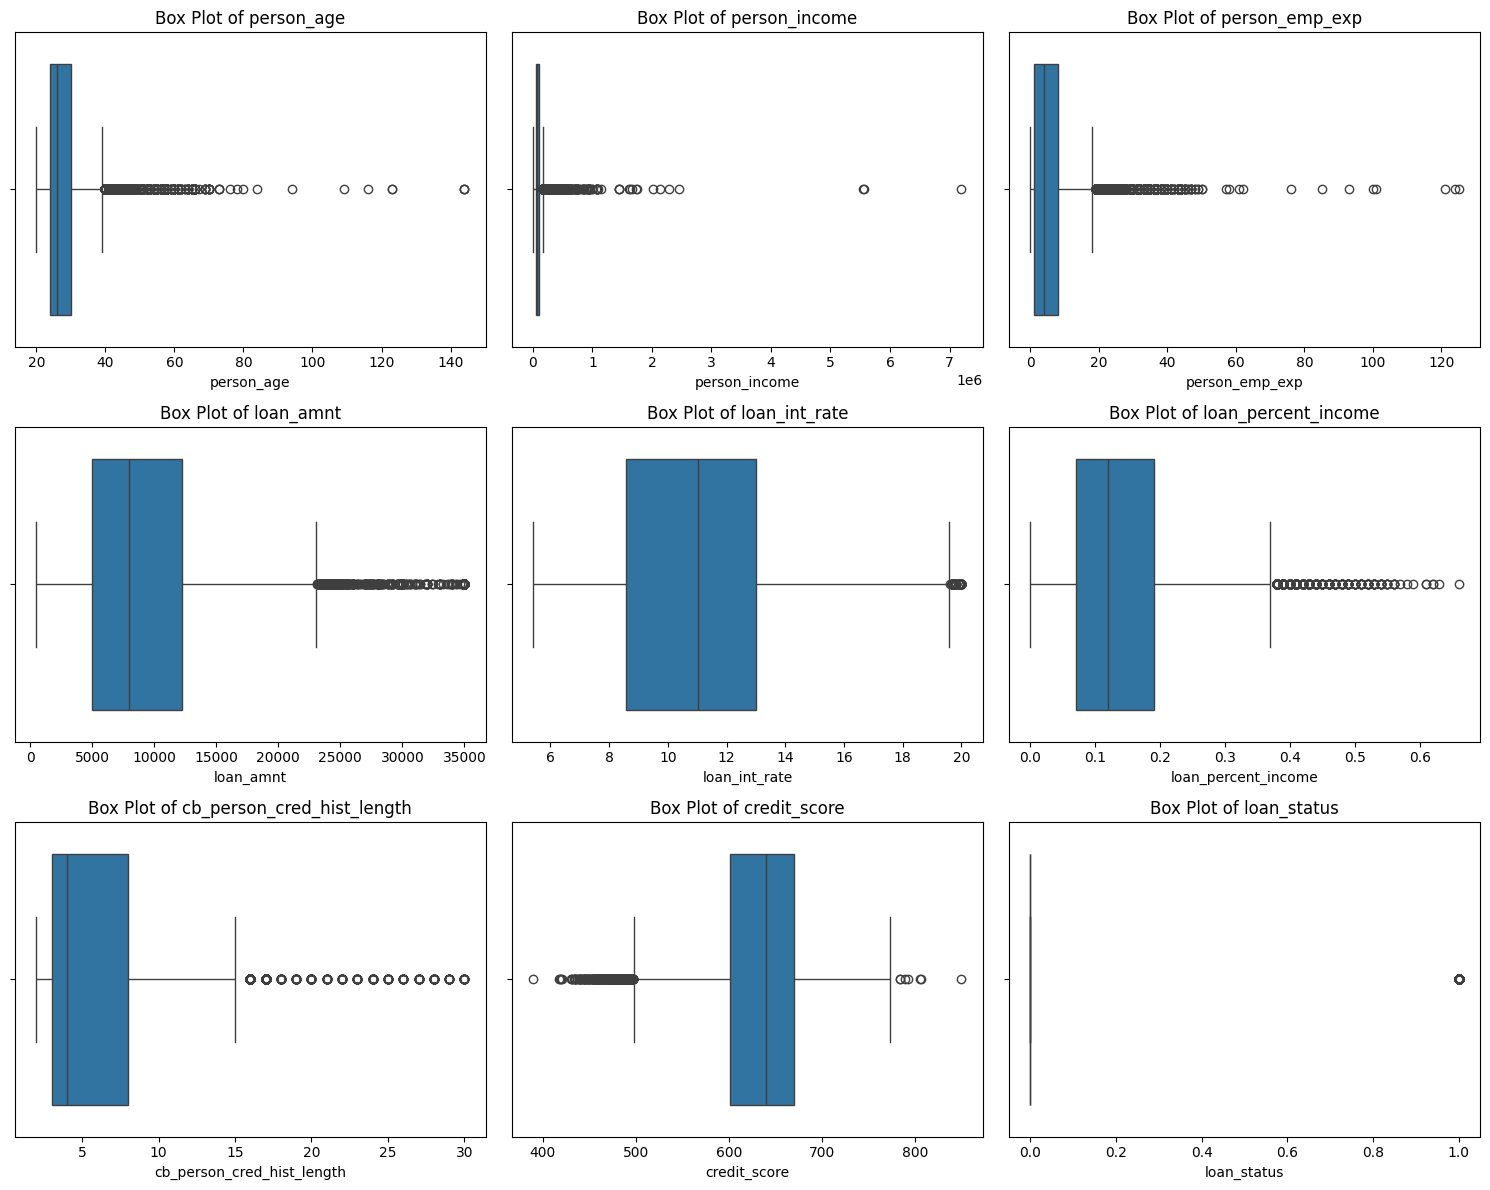

In [14]:
# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()  # Flatten in case of multiple rows

for i, col in enumerate(numeric_columns):
    sns.boxplot(x=data[col], ax=axes[i])
    axes[i].set_title(f"Box Plot of {col}")
    axes[i].set_xlabel(col)

# Hide unused subplots (if any)
for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

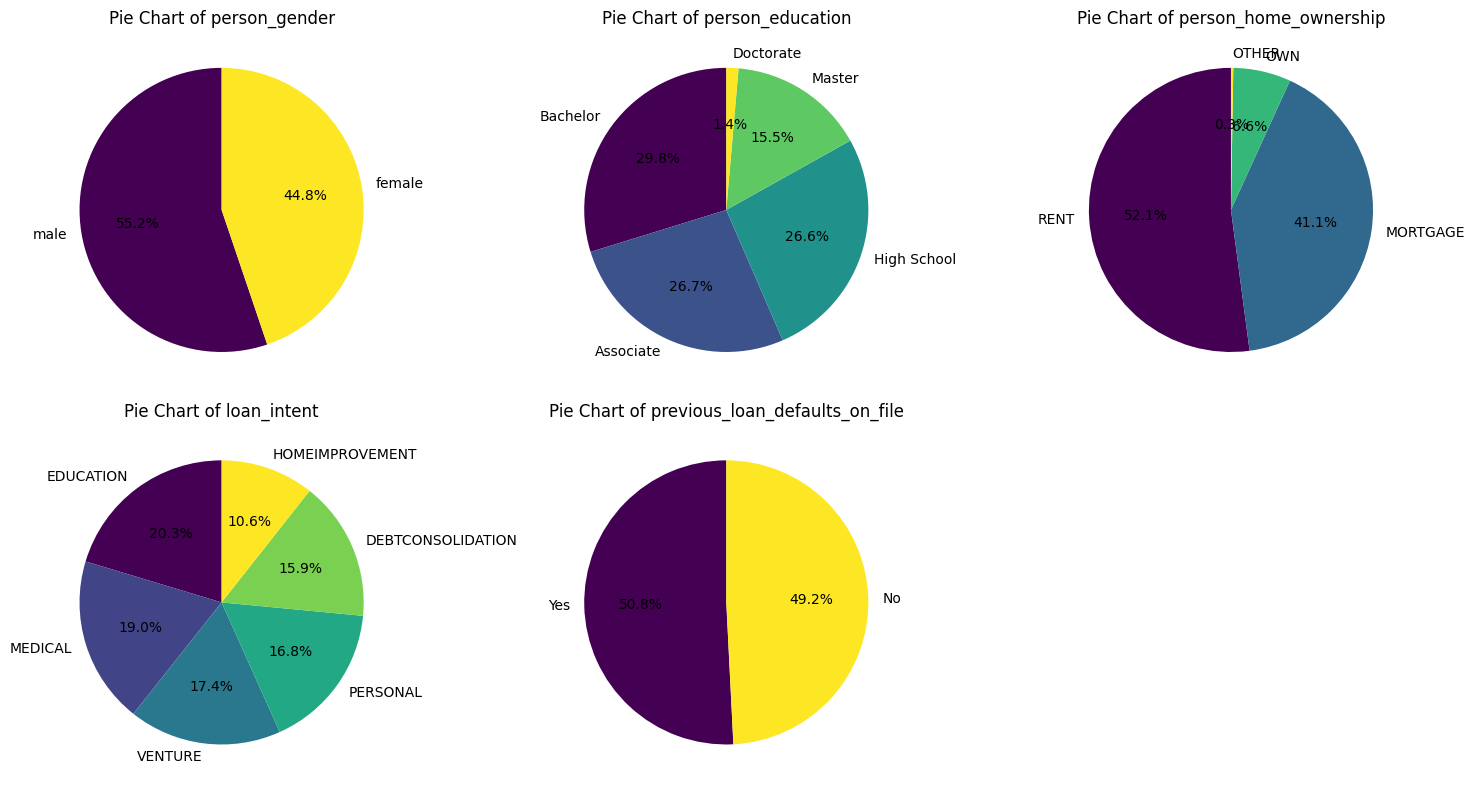

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Select categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Define number of columns for subplots
num_cols = 3  # Number of pie charts per row
num_rows = -(-len(categorical_columns) // num_cols)  # Compute required rows (ceiling division)

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
axes = axes.flatten()  # Flatten in case of multiple rows

# Plot pie charts
for i, col in enumerate(categorical_columns):
    data[col].value_counts().plot.pie(
        autopct='%1.1f%%', startangle=90, cmap='viridis', ax=axes[i]
    )
    axes[i].set_title(f"Pie Chart of {col}")
    axes[i].set_ylabel("")  # Remove default y-label

# Hide unused subplots (if any)
for i in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

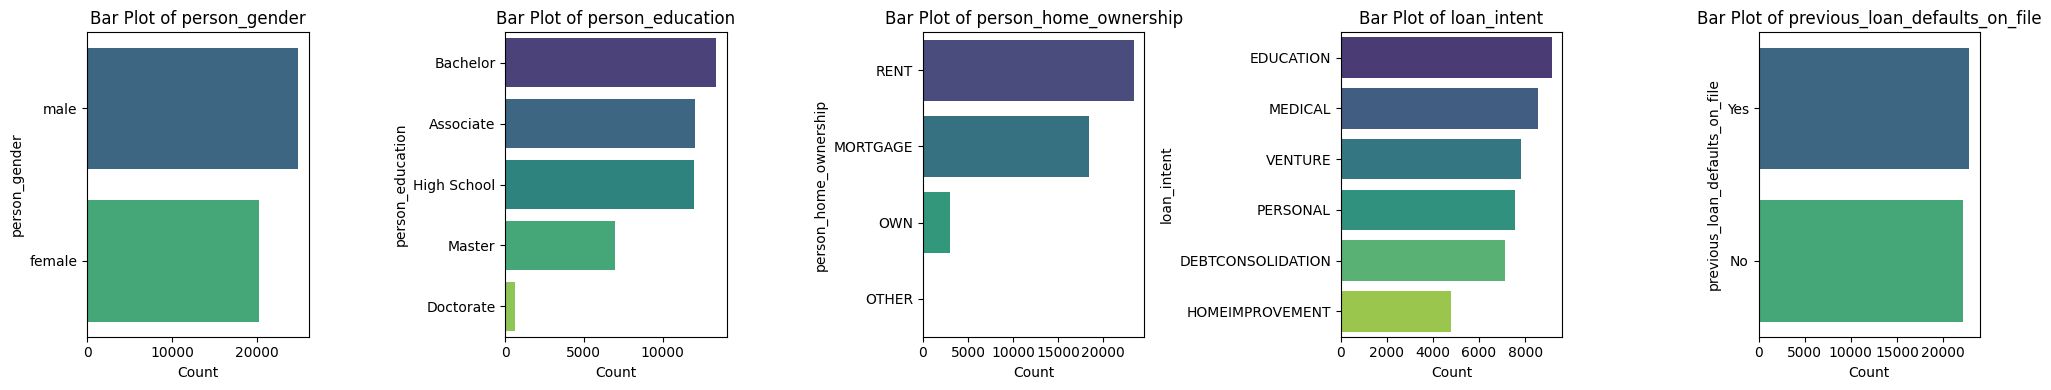

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define categorical columns
categorical_columns = ["person_gender", "person_education", "person_home_ownership", "loan_intent", "previous_loan_defaults_on_file"]

# Set up the figure size and layout
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_columns), figsize=(20, 4))

# Create bar plots for each categorical column
for ax, col in zip(axes, categorical_columns):
    sns.countplot(y=data[col], palette="viridis", order=data[col].value_counts().index, ax=ax)
    ax.set_title(f"Bar Plot of {col}")
    ax.set_xlabel("Count")
    ax.set_ylabel(col)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [17]:
print(f'The dataset has {data.shape[0]} rows and {data.shape[1]} columns.')

The dataset has 45000 rows and 14 columns.


In [19]:
# Define numeric features
numeric_features = data.select_dtypes(include=['float64', 'int64']).columns

# Outlier detection using IQR
Q1 = data[numeric_features].quantile(0.25)  # First quartile
Q3 = data[numeric_features].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile range

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Flag rows with outliers
outliers = ((data[numeric_features] < lower_bound) | (data[numeric_features] > upper_bound)).any(axis=1)

# Remove outliers
data_no_outliers = data[~outliers]

print(f"Number of outliers removed: {outliers.sum()}")
print(f"Data shape after removing outliers: {data_no_outliers.shape}")

Number of outliers removed: 15438
Data shape after removing outliers: (29562, 14)


In [21]:
from scipy.stats import skew

# Check skewness
skewed_features = data[numeric_features].apply(lambda x: skew(x.dropna()))
skewed_features = skewed_features[abs(skewed_features) > 0.75]  # Threshold for high skewness

# Apply log transformation to reduce skewness
for feature in skewed_features.index:
    data[feature] = data[feature].apply(lambda x: np.log1p(x) if x > 0 else x)

In [22]:
# One-Hot Encoding
# Check the columns in the DataFrame
print("Columns in the dataset:")
print(data.columns)

# Define categorical columns correctly based on the dataset
categorical_columns = ['person_gender', 'person_education', 'person_home_ownership', 
                       'loan_intent', 'previous_loan_defaults_on_file']

# Ensure all columns in `categorical_columns` exist in the DataFrame
categorical_columns = [col for col in categorical_columns if col in data.columns]

# Apply one-hot encoding
encoded_data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

print("Data after one-hot encoding:")
print(encoded_data.head())

Columns in the dataset:
Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')
Data after one-hot encoding:
   person_age  person_income  person_emp_exp  loan_amnt  loan_int_rate  \
0    1.419607      11.183713        0.000000  10.463132          16.02   
1    1.408800       9.415971        0.000000   6.908755          11.14   
2    1.448822       9.428592        1.386294   8.612685          12.87   
3    1.429846      11.286702        0.000000  10.463132          15.23   
4    1.439569      11.099469        0.693147  10.463132          14.27   

   loan_percent_income  cb_person_cred_hist_length  credit_score  loan_status  \
0             0.335598                    1.386294           561     0.526589   
1             0

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

print("Data after Min-Max Scaling:")
print(data.head())

Data after Min-Max Scaling:
   person_age person_gender person_education  person_income  person_emp_exp  \
0    0.056960        female           Master       0.322886        0.000000   
1    0.029286        female      High School       0.063015        0.000000   
2    0.131773        female      High School       0.064870        0.286645   
3    0.083178        female         Bachelor       0.338026        0.000000   
4    0.108077          male           Master       0.310501        0.143322   

  person_home_ownership  loan_amnt loan_intent  loan_int_rate  \
0                  RENT   1.000000    PERSONAL       0.727023   
1                   OWN   0.162992   EDUCATION       0.392318   
2              MORTGAGE   0.564245     MEDICAL       0.510974   
3                  RENT   1.000000     MEDICAL       0.672840   
4                  RENT   1.000000     MEDICAL       0.606996   

   loan_percent_income  cb_person_cred_hist_length  credit_score  \
0             0.818531                

In [25]:
X=data.iloc[:,0:-1]
y=data.loan_status

In [26]:
from sklearn.model_selection import train_test_split
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (31500, 13)
X_test shape: (13500, 13)
y_train shape: (31500,)
y_test shape: (13500,)


In [27]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Encode categorical variables using LabelEncoder for binary columns
label_encoders = {}
binary_columns = ["person_gender", "previous_loan_defaults_on_file"]

for col in binary_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# One-hot encoding for multi-category columns
data = pd.get_dummies(data, columns=["person_education", "person_home_ownership", "loan_intent"], drop_first=True)

# Define features (X) and target variable (y)
X = data.drop(columns=["loan_status"])
y = data["loan_status"]

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 92.93%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96      6990
         1.0       0.90      0.77      0.83      2010

    accuracy                           0.93      9000
   macro avg       0.92      0.87      0.89      9000
weighted avg       0.93      0.93      0.93      9000

Confusion Matrix:
[[6817  173]
 [ 463 1547]]


In [28]:
from sklearn.linear_model import LogisticRegression

# Initialize the model
log_reg_model = LogisticRegression(random_state=42)

# Train the model
log_reg_model.fit(X_train, y_train)

# Predict on the test data
y_pred_log_reg = log_reg_model.predict(X_test)

# Evaluate the model's performance
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
print(f"Accuracy: {accuracy_log_reg * 100:.2f}%")

# Display the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

# Display the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_log_reg))

Accuracy: 89.72%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93      6990
         1.0       0.78      0.75      0.77      2010

    accuracy                           0.90      9000
   macro avg       0.85      0.85      0.85      9000
weighted avg       0.90      0.90      0.90      9000

Confusion Matrix:
[[6564  426]
 [ 499 1511]]


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Example y_true (true values) and y_pred (predicted values)
#y_true = [3.0, 2.5, 4.0, 5.1]
#y_pred = [2.8, 2.7, 4.1, 5.0]

# MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)

# MSE (Mean Squared Error)
mse = mean_squared_error(y_test, y_pred)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

# R2 Score
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 0.07066666666666667
MSE: 0.07066666666666667
RMSE: 0.26583202716502513
R²: 0.5925949650887193


In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import numpy as np
# Example y_true (true labels) and y_pred (predicted labels)
#y_true = [0, 1, 1, 0, 1, 0, 1, 1]
#y_pred = [0, 1, 0, 0, 1, 1, 1, 0] 

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred)

# F1 Score
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Accuracy: 0.9293333333333333
Confusion Matrix:
[[6817  173]
 [ 463 1547]]
Recall: 0.7696517412935323
Precision: 0.8994186046511627
F1 Score: 0.8294906166219839
